# Implementation of a Hybrid Quantum Neural Network with entangled states
## The notebook below implements a Hybrid Neural Network consisting of a Quantum Hidden Layers sandwiched between classical neural hidden layers 
    - The implementation is a muticlass classifier that tries to predict the 3 output classes
    - This is a novel algorithm that is not implemented on the pennylane tutorial website
    - The dataset used is IRIS flower classification dataset, with 4 input features and 3 output classes
    - The performance is evaluated on the test dataset with train-test split of 75%:25%import pennylane as qml


In [1]:
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np
from tensorflow.keras import Input, Model
tf.random.set_seed(221)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout

## Defining the Model Parameters

In [2]:
nqubits = 4
n_layers = 3
output_size = 3
batch_size = 32
l_r = 0.05
num_epochs = 20
dropout_thresh = 0.1
model_type = 0 # 0 for expected values as output and 1 for probability distribution as output of the quantum layer

In [3]:
device = qml.device('default.qubit', wires=nqubits)

## Defining the hidden quantum layer which will be repeated num_layers times i.e. 3 times

### 1. Hidden Quantum layer to output expected values

In [4]:
# Define QNode that outputs expected values of a distribution
@qml.qnode(device)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(nqubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(nqubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]

### 2. Hidden Quantum layer to output probability distribution (num_qubits**2)

In [5]:
# Define QNode that outputs the probability distribution
@qml.qnode(device, interface="tf")
def qnode_probs(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(nqubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(nqubits))
    return qml.probs(wires=range(nqubits))

## Implementing the training procedure

### 1. Loading the dataset

In [6]:
num_features= 4
data = np.loadtxt("multiclass_classification/iris.csv", delimiter=",")
np.random.shuffle(data)
validation_split = 0.75
X = data[:, 0:num_features]
Y = data[:, -1].astype(int)

### 2. normalizing the dataset

In [8]:
# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
num_train = int(validation_split * len(data))
index = np.random.permutation(range(len(data)))
X_train = X_norm[index[:num_train]]
Y_train = Y[index[:num_train]]
X_val = X_norm[index[num_train:]]
Y_val = Y[index[num_train:]]

### 3. preparing the data for the Hybrid Neural Network

In [10]:
# inputs = tf.constant(np.random.random((batches, nqubits)), dtype=tf.float32)
inputs = tf.constant(X_train, dtype=tf.float32)
# output_size is the number of classes
outputs = tf.one_hot(Y_train, depth=output_size)

inputs_test = tf.constant(X_val, dtype=tf.float32)
# output_size is the number of classes
outputs_test = tf.one_hot(Y_val, depth=output_size)

# define weight_shapes
weight_shapes = {"weights": (n_layers, nqubits, 3)}
ip = Input(shape=(1, num_features))

### 4. Defining the model architecture of Hybrid Neural network

In [11]:
if model_type==0:
    model = Sequential()
    model.add(Dense(num_features, activation='tanh'))
    model.add(Dropout(dropout_thresh))
    model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=nqubits))
    model.add(Dense(output_size, activation='softmax'))
elif model_type==1:
    model = Sequential()
    model.add(Dense(num_features, activation='tanh'))
    model.add(Dropout(dropout_thresh))
    model.add(qml.qnn.KerasLayer(qnode_probs, weight_shapes, output_dim=nqubits**2))
    model.add(Dense(output_size, activation='softmax'))

### 4. Training the Hybrid Neural Network

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(inputs, outputs, validation_data=(inputs_test,outputs_test), epochs=num_epochs, batch_size=batch_size, callbacks=[tensorboard_callback])
model.summary()
preds = model.predict(inputs)

Epoch 1/20
1/4 [======>.......................] - ETA: 0s - loss: 1.1555 - accuracy: 0.3438WARNING:tensorflow:From /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


4/4 [==============================] - 25s 6s/step - loss: 1.1549 - accuracy: 0.2857 - val_loss: 1.1095 - val_accuracy: 0.2895
Epoch 2/20
4/4 [==============================] - 25s 6s/step - loss: 1.0935 - accuracy: 0.3304 - val_loss: 1.0771 - val_accuracy: 0.3947
Epoch 3/20
4/4 [==============================] - 25s 6s/step - loss: 1.0883 - accuracy: 0.3750 - val_loss: 1.0163 - val_accuracy: 0.6842
Epoch 4/20
4/4 [==============================] - 25s 6s/step - loss: 0.9890 - accuracy: 0.6161 - val_loss: 0.8251 - val_accuracy: 0.6842
Epoch 5/20
4/4 [==============================] - 24s 6s/step - loss: 0.7792 - accuracy: 0.6696 - val_loss: 0.5442 - val_accuracy: 0.6842
Epoch 6/20
4/4 [==============================] - 24s 6s/step - loss: 0.5686 - accuracy: 0.7321 - val_loss: 0.4431 - val_accuracy: 0.6842
Epoch 7/20
4/4 [==============================] - 24s 6s/step - loss: 0.4753 - accuracy: 0.7589 - val_loss: 0.3724 - val_accuracy: 1.0000
Epoch 8/20
4/4 [=============================

In [13]:
%tensorboard --logdir ./logs

In [14]:
preds = model.predict(inputs_test)

In [16]:
preds_class = np.argmax(preds, axis=1)

In [20]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_val, preds_class))

[[15  0  0]
 [ 0 12  0]
 [ 0  0 11]]


In [18]:
Y_val

tensor([0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 0,
        1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0], requires_grad=True)

In [23]:
costs_list = [1.15492785,1.093549967,1.088335991,0.98901695,0.779222369,0.568623602,0.475314617,0.443673879,0.406995326,0.392662257,0.310847223,0.314099789,0.315703005,0.33104375,0.321631938,0.2570104,0.348391533,0.286213249,0.261734635,0.205957994]
train_acc = [0.285714298,0.330357134,0.375,0.616071403,0.669642866,0.732142866,0.758928597,0.830357134,0.866071403,0.848214269,0.928571403,0.875,0.883928597,0.866071403,0.848214269,0.892857134,0.839285731,0.892857134,0.901785731,0.9375]
test_acc = [0.289473683,0.394736856,0.684210539,0.684210539,0.684210539,0.684210539,1,1,0.921052635,0.842105269,1,0.973684192,0.894736826,0.894736826,0.973684192,0.842105269,0.973684192,0.973684192,1,1]

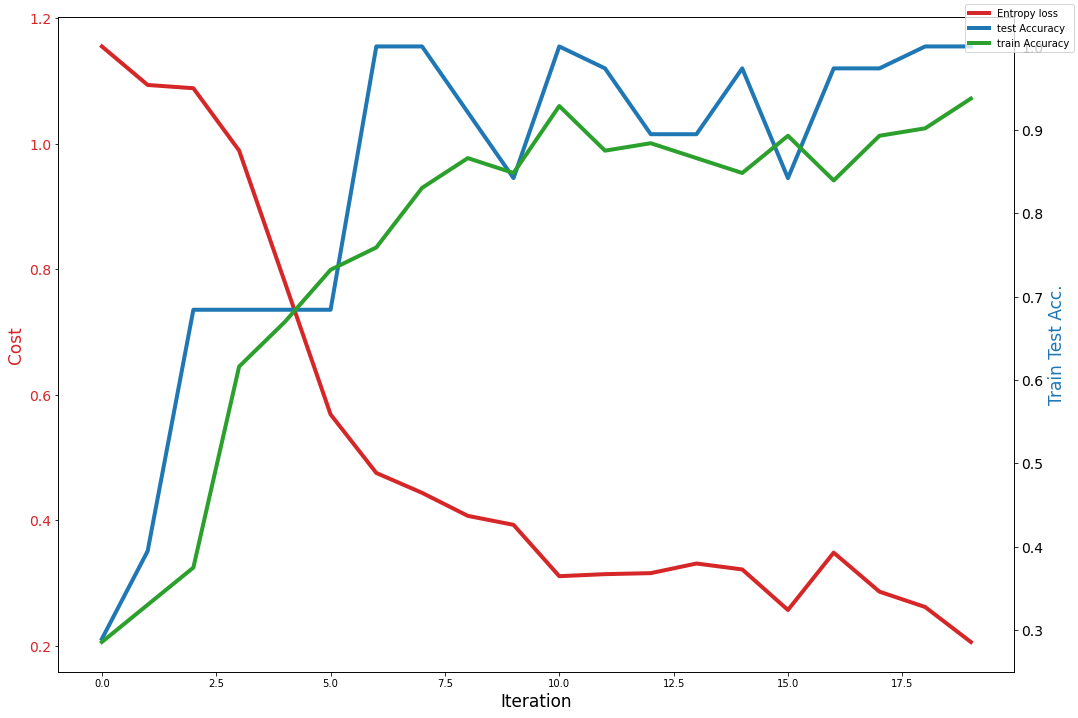

In [26]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 10))
iters = np.arange(0, num_epochs, 1)
colors = ["tab:red", "tab:blue", "tab:green"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs_list, color=colors[0], linewidth=4, label='Entropy loss')
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Train Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4, label='test Accuracy')
ax2.plot(iters, train_acc, color=colors[2], linewidth=4, label='train Accuracy')


ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

plt.grid(False)
plt.tight_layout()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines, labels)
plt.show()

In [29]:
from sklearn.metrics import classification_report, jaccard_score

In [30]:
print(classification_report(Y_val, preds_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        11

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [31]:
jaccard_score(Y_val, preds_class, average='weighted')

1.0